In [1]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
import seaborn as sns
import numpy as np
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, recall_score

In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
# Parameters
num_classes = 2  # Update this based on the number of classes in your dataset
batch_size = 16
number_of_epochs = 30
learning_rate = 0.001

In [4]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)


In [6]:
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [7]:
# Initialize the model
model = models.mobilenet_v2(pretrained=True)

/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Modify the classifier to fit the number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:
# Initialize a dictionary to store metrics
history = {
    'accuracy': [],
    'loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_precision': []
}

# Train the model
for epoch in range(number_of_epochs):
    model.train()
    running_loss = 0.0
    train_predictions = []
    train_labels = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Track predictions and true labels for training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_predictions.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    # Calculate training loss and accuracy
    epoch_loss = running_loss / len(train_loader.dataset)
    history['loss'].append(epoch_loss)
    train_accuracy = accuracy_score(train_labels, train_predictions) * 100
    history['accuracy'].append(train_accuracy)

    # Validate the model
    model.eval()
    val_labels = []
    val_predictions = []
    val_running_loss = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    
    precision = precision_score(all_labels, all_predictions, average='macro')
    

    print(f'Epoch [{epoch+1}/{number_of_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {precision:.4f}')

Epoch [1/30], Loss: 0.6936, Accuracy: 61.86%, Precision: 0.8077
Epoch [2/30], Loss: 0.4711, Accuracy: 80.93%, Precision: 0.7963


/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/30], Loss: 0.3775, Accuracy: 83.51%, Precision: 0.2143
Epoch [4/30], Loss: 0.1871, Accuracy: 95.36%, Precision: 0.7556
Epoch [5/30], Loss: 0.1986, Accuracy: 93.30%, Precision: 0.7400
Epoch [6/30], Loss: 0.1911, Accuracy: 92.27%, Precision: 0.7609
Epoch [7/30], Loss: 0.6096, Accuracy: 71.13%, Precision: 0.5455
Epoch [8/30], Loss: 0.2572, Accuracy: 91.75%, Precision: 0.7460
Epoch [9/30], Loss: 0.1105, Accuracy: 96.91%, Precision: 0.7222
Epoch [10/30], Loss: 0.1160, Accuracy: 96.39%, Precision: 0.6905
Epoch [11/30], Loss: 0.4022, Accuracy: 82.47%, Precision: 0.6333


/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [12/30], Loss: 0.2160, Accuracy: 93.81%, Precision: 0.2143
Epoch [13/30], Loss: 0.2563, Accuracy: 91.24%, Precision: 0.7143
Epoch [14/30], Loss: 0.1486, Accuracy: 96.39%, Precision: 0.7462
Epoch [15/30], Loss: 0.1097, Accuracy: 97.42%, Precision: 0.8125
Epoch [16/30], Loss: 0.2054, Accuracy: 94.85%, Precision: 0.7460
Epoch [17/30], Loss: 0.0435, Accuracy: 99.48%, Precision: 0.7727
Epoch [18/30], Loss: 0.0811, Accuracy: 95.88%, Precision: 0.7576
Epoch [19/30], Loss: 0.0298, Accuracy: 98.45%, Precision: 0.8542
Epoch [20/30], Loss: 0.1609, Accuracy: 94.33%, Precision: 0.7292
Epoch [21/30], Loss: 0.3327, Accuracy: 86.08%, Precision: 0.4583
Epoch [22/30], Loss: 0.1757, Accuracy: 93.30%, Precision: 0.6042
Epoch [23/30], Loss: 0.0971, Accuracy: 96.39%, Precision: 0.8333
Epoch [24/30], Loss: 0.0566, Accuracy: 96.91%, Precision: 0.8392
Epoch [25/30], Loss: 0.0469, Accuracy: 97.94%, Precision: 0.8392
Epoch [26/30], Loss: 0.3287, Accuracy: 89.18%, Precision: 0.8158
Epoch [27/30], Loss: 0.18

In [12]:
# Save the model, optional
torch.save(model.state_dict(), f'Pth_Files/Mobilenet_model_{number_of_epochs}.keras')

In [13]:
def predict_class(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert image to RGB if not

    # Apply the transformations
    input_image = transform(image).unsqueeze(0)  # Add batch dimens

    # Predict the class
    with torch.no_grad():  # No need to track gradients for inference
        output = model(input_image)
        _, predicted = torch.max(output.data, 1)  # Get the index of the max log-probability

    # Assuming you have a list of class names corresponding to your label indices
    class_names = ['class1', 'class2']  # Fill in your actual class names
    predicted_class = class_names[predicted.item()]

    print(f'Predicted Class: {predicted_class}')

In [14]:
image_1 = test_dir + "/edible/Agaricus_abruptibulbus/Agaricus_abruptibulbus_1.jpg"
image_2 = test_dir + "/poisonous/Amanita_excelsa/Amanita_excelsa_1.jpg"
image_3 = test_dir + "/edible/Agaricus_abruptibulbus/Agaricus_abruptibulbus_2.jpg"

In [15]:
predict_class(image_1)
predict_class(image_3)
predict_class(image_2)

Predicted Class: class2
Predicted Class: class2
Predicted Class: class1


## Results

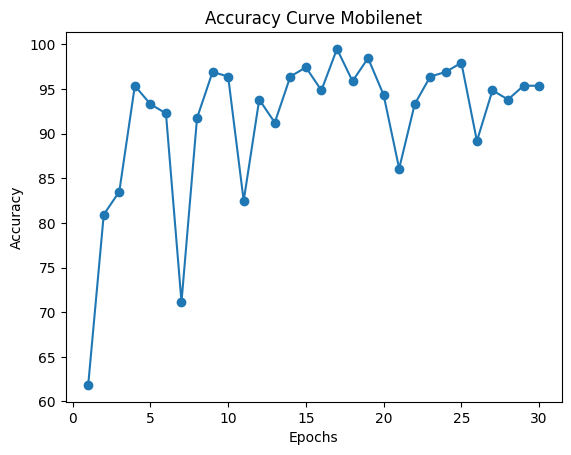

In [16]:
# Plot training & validation accuracy values
acc = history['accuracy']
epochs = range(1, len(acc) + 1)

# Plotting the accuracy curve
plt.plot(range(1, number_of_epochs + 1), acc, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve Mobilenet')
plt.show()

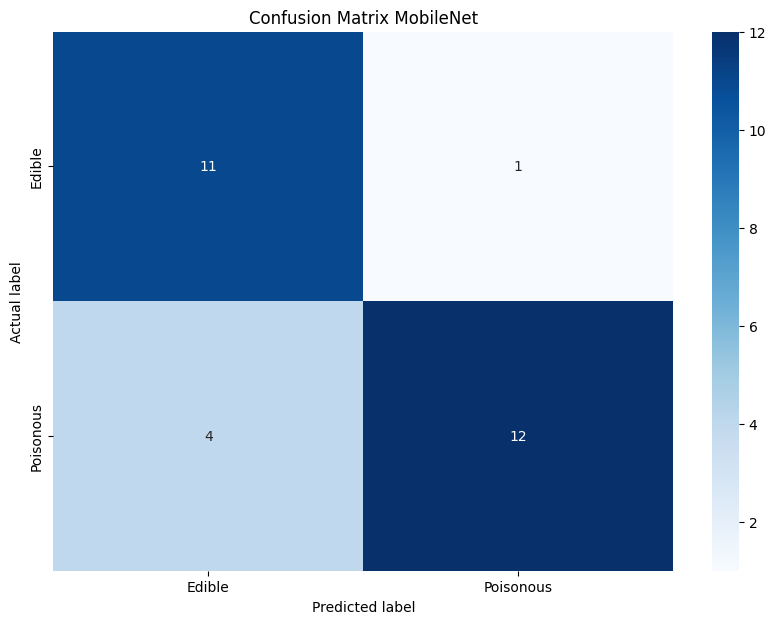

In [17]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Edible', 'Poisonous'], yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix MobileNet')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
print("Classification Report MobileNet:")
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Create a DataFrame to display the results in tabular format
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})

# Display the DataFrame
print(metrics_df.to_string(index=False))

Classification Report MobileNet:
   Metric    Score
 Accuracy 0.821429
Precision 0.841758
   Recall 0.821429
 F1 Score 0.822113
